In [1]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp
from scipy.special import legendre
import jax
import optax

from time import time
import pickle

import matplotlib.pyplot as plt


import os, sys, argparse

parent = os.path.abspath('../src')
sys.path.insert(1, parent)

from perceptron import Perceptron



# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")


In [2]:

def get_loss_function(perceptron, ts, H_obj, dev):

    @jax.jit
    @qml.qnode(dev, interface="jax")
    def loss(param_vector):

        # hamitlonian_params = dictionary_to_hamiltonian_parameters(params_dict)

        param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

        qml.evolve(perceptron.H)(param_list, ts)

        return qml.expval(H_obj)

    return loss


In [4]:

# setting up the problem
perceptron_qubits = 8
pulse_basis = 5
ts = jnp.array([0.0, 1.0])

dev = qml.device("default.qubit.jax", wires = perceptron_qubits)


perceptron = Perceptron(perceptron_qubits, pulse_basis, basis='gaussian', pulse_width=0.05)

H =  perceptron.H

H_obj, H_obj_spectrum = perceptron.get_1d_ising_hamiltonian(0.1)

e_ground_state_exact = H_obj_spectrum[0]

print(f'Ising Model Hamiltonian:\nH = {H_obj}')
print(f'Exact ground state energy: {e_ground_state_exact}')


Ising Model Hamiltonian:
H =   (0.1) [X0]
+ (0.1) [X1]
+ (0.1) [X2]
+ (0.1) [X3]
+ (0.1) [X4]
+ (0.1) [X5]
+ (0.1) [X6]
+ (0.1) [X7]
+ (1.0) [Z0 Z1]
+ (1.0) [Z1 Z2]
+ (1.0) [Z2 Z3]
+ (1.0) [Z3 Z4]
+ (1.0) [Z4 Z5]
+ (1.0) [Z5 Z6]
+ (1.0) [Z6 Z7]
Exact ground state energy: -7.025018814832985


In [5]:
# getting the loss_function
loss = get_loss_function(perceptron, ts, H_obj, dev)

param_vector = perceptron.get_random_parameter_vector(0)

print(f'Initial parameters: {param_vector}')

print(f'Initial loss: {loss(param_vector)}')

initial_gradients = jax.grad(loss)(param_vector)
print(f'Initial gradients: {initial_gradients}')

value_and_grad = jax.jit(jax.value_and_grad(loss))

Initial parameters: [0.71112073 0.10637005 0.8212181  0.24883187 0.17793033 0.70333894
 0.01883985 0.70220909 0.06446235 0.77877441 0.32306491 0.4904092
 0.73966385 0.74715357 0.41906191 0.98934419 0.20177597 0.23874967
 0.04128388 0.25199621 0.10464045 0.73135329 0.32537487 0.22705476
 0.57643603 0.43564564 0.41347613 0.67494821 0.94425438 0.17174199
 0.49617273 0.65568882 0.7549472  0.26714188 0.50671093 0.99673463
 0.98755885 0.10709156 0.79832035 0.13024194 0.06393958 0.97922961
 0.3494657  0.28280374 0.76830562 0.29896191 0.09637728 0.24668566
 0.84562437 0.4153954  0.94017989 0.66641439 0.26391584 0.23331451
 0.21664774 0.40343998 0.90423184 0.99628013 0.60867884 0.59985139
 0.80037177 0.36323526 0.00843749 0.48758748 0.98400229 0.11984233
 0.37957    0.10668231 0.93726245 0.14377214 0.83903752 0.68087594
 0.56582413 0.34361945 0.86420552 0.49659749 0.49336309 0.89217389
 0.57659773 0.02403941 0.24791035 0.72191654 0.68318053 0.51276355
 0.50732946 0.32483704 0.61012425 0.8924468

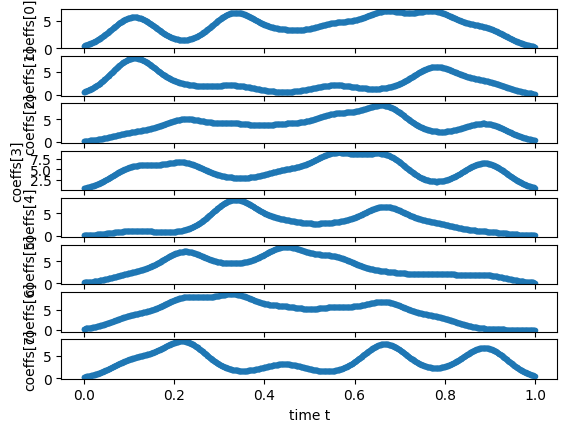

In [7]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()


In [8]:

from datetime import datetime

n_epochs = 400
param_vector = perceptron.get_random_parameter_vector(8098)


# The following block creates a constant schedule of the learning rate
# that increases from 0.1 to 0.5 after 10 epochs
schedule0 = optax.constant_schedule(1)
schedule1 = optax.constant_schedule(0.1)
schedule = optax.join_schedules([schedule0, schedule1], [50])
optimizer = optax.adam(learning_rate=schedule)
# optimizer = optax.adam(learning_rate=1)
opt_state = optimizer.init(param_vector)

energies = np.zeros(n_epochs )
# energy[0] = loss(param_vector)
mean_gradients = np.zeros(n_epochs)

gradients_trajectory = []
param_trajectory = []

## Compile the evaluation and gradient function and report compilation time
time0 = time()
_ = value_and_grad(param_vector)
time1 = time()

# print(f"grad and val compilation time: {time1 - time0}")


## Optimization loop
for n in range(n_epochs):
    val, grads = value_and_grad(param_vector)
    updates, opt_state = optimizer.update(grads, opt_state)

    mean_gradients[n] = np.mean(np.abs(grads))
    energies[n] = val
    param_trajectory.append(param_vector)
    gradients_trajectory.append(grads)

    param_vector = optax.apply_updates(param_vector, updates)

    # mean_gradients[n] = np.mean(np.abs(grads))
    # energy[n+1] = val

    # print(f"            param: {param_vector}")

    if not n % 10:
        print(f"{n+1} / {n_epochs}; energy discrepancy: {val-e_ground_state_exact}")
        print(f"mean grad: {mean_gradients[n]}")
        print(f'gradient norm: {jnp.linalg.norm(grads)}')
        if n>=2:
            print(f'difference of gradients: {jnp.linalg.norm(grads-gradients_trajectory[-2])}')


    # if jnp.linalg.norm(gradients_trajectory[n-1] - mean_gradients[n]) < 1e-3:

    #     break


print(f"Found ground state: {energies[-1]}")


1 / 400; energy discrepancy: 7.530663814933422
mean grad: 0.41224882300680343
gradient norm: 5.976735164873975
11 / 400; energy discrepancy: 6.096587246695217
mean grad: 0.39151246851923116
gradient norm: 6.0511411506775765
difference of gradients: 7.465524002970325
21 / 400; energy discrepancy: 7.275089497530005
mean grad: 0.31017727662312666
gradient norm: 5.324088220972577
difference of gradients: 9.250158865674795
31 / 400; energy discrepancy: 6.768116669764017
mean grad: 0.33689578632496153
gradient norm: 5.681910044568143
difference of gradients: 5.6105378755599595
41 / 400; energy discrepancy: 6.4740609153919015
mean grad: 0.30207843496944875
gradient norm: 5.107061568796167
difference of gradients: 8.608228811299167
51 / 400; energy discrepancy: 8.207161889043572
mean grad: 0.26433544328790526
gradient norm: 4.472052697576958
difference of gradients: 6.5652806093848595
61 / 400; energy discrepancy: 5.215170367849288
mean grad: 0.32433952030045365
gradient norm: 5.17345344788722

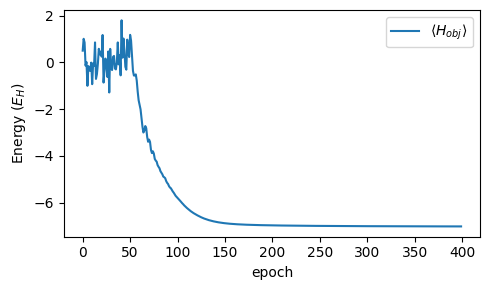

In [9]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = energies 
ax.plot(y, label="$\\langle H_{{obj}}\\rangle$")
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle$")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

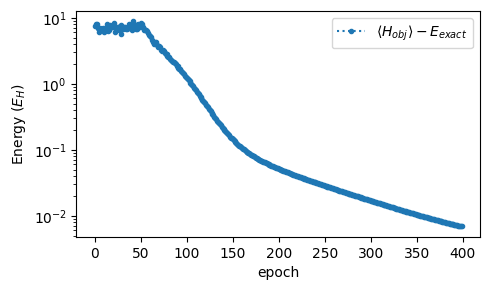

In [10]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = energies - e_ground_state_exact
ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

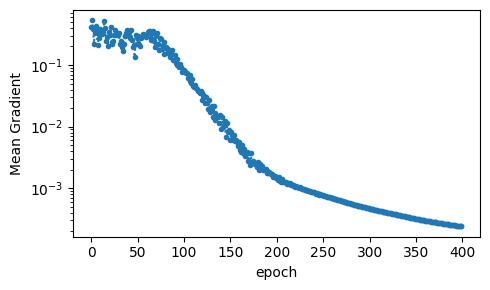

In [11]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = mean_gradients
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Mean Gradient")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

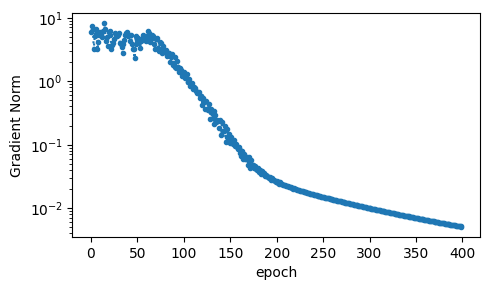

In [12]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = [jnp.linalg.norm(gradient) for gradient in gradients_trajectory]
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Gradient Norm")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

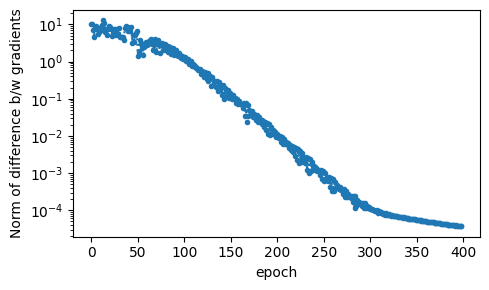

In [13]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = [jnp.linalg.norm(gradients_trajectory[j] - gradients_trajectory[j-1]) for j in range(1,len(gradients_trajectory))]
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Norm of difference b/w gradients")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

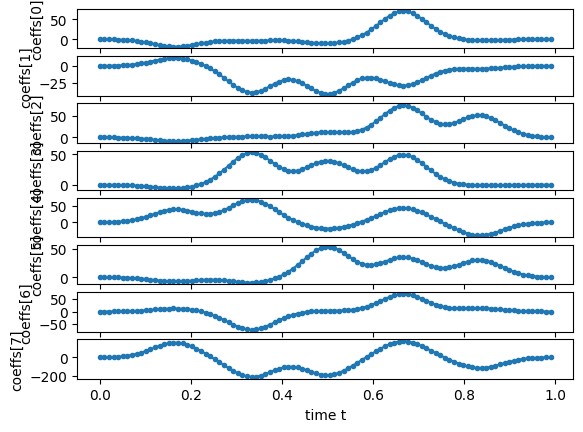

In [20]:
ts = jnp.linspace(0.0, 1, 100)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()

In [21]:
# Calculating the Final Hessian

final_hessian = jax.jacrev(jax.jacrev(loss))(param_vector)
final_hessian_eigenvalues = jnp.linalg.eigvals(final_hessian)
final_hessian_eigenvalues

Array([ 3.14075158e+01+0.00000000e+00j,  2.51661197e+01+0.00000000e+00j,
        2.15380501e+01+0.00000000e+00j,  1.66529912e+01+0.00000000e+00j,
        1.51514626e+01+0.00000000e+00j,  1.33480071e+01+0.00000000e+00j,
        1.06508583e+01+0.00000000e+00j,  9.13305698e+00+0.00000000e+00j,
        7.40277027e+00+0.00000000e+00j,  5.26620397e+00+0.00000000e+00j,
        4.97771034e+00+0.00000000e+00j,  4.91903990e+00+0.00000000e+00j,
        8.32700270e-01+0.00000000e+00j,  8.11341107e-01+0.00000000e+00j,
        5.08798284e-01+0.00000000e+00j,  8.48426780e-02+0.00000000e+00j,
        4.74372988e-02+0.00000000e+00j,  3.88260319e-02+0.00000000e+00j,
        3.71597041e-02+0.00000000e+00j,  1.25641211e-02+0.00000000e+00j,
        5.85452090e-03+0.00000000e+00j,  4.69569204e-03+0.00000000e+00j,
        2.79050233e-03+0.00000000e+00j,  2.08669075e-03+0.00000000e+00j,
        1.76265177e-03+0.00000000e+00j, -1.25322564e-03+0.00000000e+00j,
        1.44400623e-03+0.00000000e+00j,  1.10923230

/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


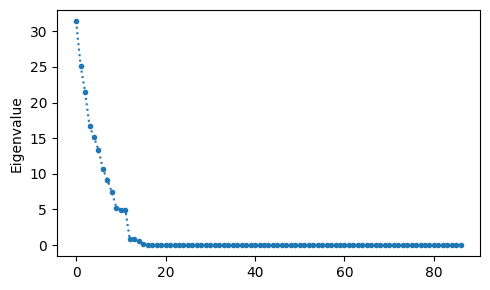

In [22]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = np.linalg.eigvals(final_hessian)

# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Eigenvalue")
# ax.set_xlabel("Eigenvalue")
# ax.legend()

plt.tight_layout()
plt.show()